In [1]:
import os
import sys
import torch
import numpy as np
from torch import matmul as m
from matplotlib import pyplot as plt
from sdes import SDE,ConstantDiffusion,TwoDimensionalSynDrift,DoubleWellDrift,MaxDiffusion
from torch.autograd.functional import jacobian

from torch.distributions import MultivariateNormal

sys.path.insert(0,".")

from utils import define_grid_ranges,define_mesh_points
from gps import MultivariateNormal,white_noise_kernel
from sde_sparse_gp import SparseGPSDE


# Run SDEs

In [12]:
dt = 0.002
number_of_steps = 5000
num_paths = 3
sigma = 1.

x_0 = torch.rand((1,)).unsqueeze(-1)
real_drift = DoubleWellDrift(a=4.,b=4.)
diffusion = ConstantDiffusion(sigma=sigma)

#x_0 = torch.rand((2,)).unsqueeze(0)
#drift = TwoDimensionalSynDrift()
#diffusion = ConstantDiffusion(sigma=sigma)

two_dimensional_sde = SDE(real_drift,diffusion,dt=dt)
dense_path_realization = two_dimensional_sde.simulate(x_0, number_of_steps, num_paths=num_paths)
dense_path_realization = dense_path_realization[0,:,:]

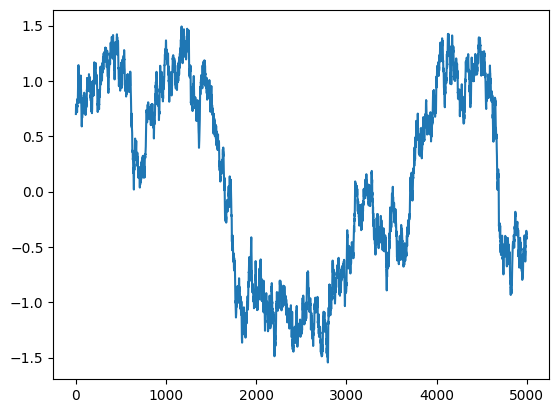

In [13]:
plt.plot(dense_path_realization[:,0].detach().numpy())

### Select path and evaluation grid

In [14]:
from utils import define_grid_ranges,define_mesh_points
from sde_gp import DenseGPSDE

num_evaluation_points = 2000
num_inducing_points = 500

dimensions = dense_path_realization.size(1)
num_dense_points = dense_path_realization.size(0)

ranges_ = define_grid_ranges(dense_path_realization,ignore_percentatge=0.05)
evaluation_points = define_mesh_points(total_points = num_evaluation_points,n_dims = dimensions, ranges=ranges_)

### Inference

In [15]:
from gpytorch.kernels import (
    RBFKernel, 
    ScaleKernel,
    PolynomialKernel
)

In [16]:
#kernels=[PolynomialKernel(power=4)]
sparse_gp_sde = SparseGPSDE(dense_path_realization,
                            dt=dt,
                            kernels=[PolynomialKernel(power=4)],
                            kernel_parameters = None,
                            num_inducing_points=3000,
                            realization_as_inducing=False)
sparse_gp_sde.inference(diffusion)
F = sparse_gp_sde(evaluation_points)
f_x = F[:,0]

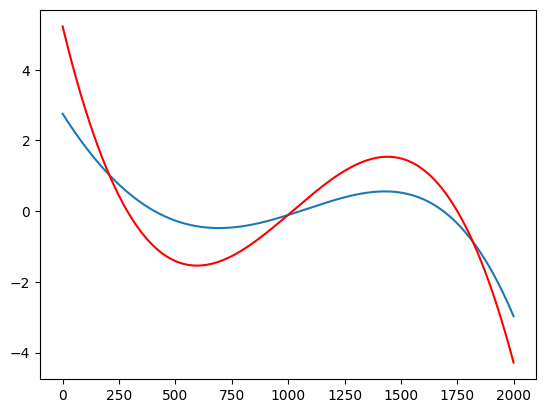

In [17]:
# real drift for comparison
real_drift_ = real_drift(evaluation_points)
plt.plot(f_x.detach().numpy())
plt.plot(real_drift_[:,0].detach().numpy(),"r-")
plt.show()